In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [3]:
# Image size for the input
IMAGE_SIZE = (224, 224)

# Image size + channels for the input
INPUT_IMAGE_SIZE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

# Delving Deeper into Conolutional Neural Networks

In [4]:
model = Sequential([
    Input(shape=INPUT_IMAGE_SIZE),
    Conv2D(20, 3, padding = "same", activation = tf.keras.activations.relu),
    Conv2D(20, 3, padding = "same", activation = tf.keras.activations.relu),
    MaxPool2D(),
    Conv2D(50, 3, padding = "same", activation = tf.keras.activations.relu),
    Conv2D(50, 3, padding = "same", activation = tf.keras.activations.relu),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(100, 3, padding = "same", activation = tf.keras.activations.relu),
    Conv2D(100, 3, padding = "same", activation = tf.keras.activations.relu),
    MaxPool2D(),
    Flatten(),
    Dense(units=20, activation=tf.keras.activations.relu),
    Dense(units=2, activation=tf.keras.activations.sigmoid)
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 20)      560       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 20)      3620      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 20)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 50)      9050      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 50)      22550     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 50)        2

In [6]:
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = [SparseCategoricalAccuracy()]
)

Test and train data

Download the set from Kaggle

https://www.kaggle.com/c/dogs-vs-cats/data

Note: Pictures have different sizes

In [7]:
BASE_DIR = os.path.abspath("./dogs-vs-cats/train")

In [8]:
filenames = []
for image_class in os.listdir(BASE_DIR):    
    folder_name = os.path.join(BASE_DIR,image_class)
    filenames.append(image_class)

In [9]:
len(filenames)

25000

In [10]:
# Reduce the dataset for the example
train_filenames = filenames[:90]
val_filenames = filenames[90:100]

In [11]:
class_map = {
    "cat" : 0,
    "dog" : 1
}

In [12]:
train_classes = [class_map[f[:3]] for f in train_filenames]
train_filenames = np.array([os.path.join(BASE_DIR,f) for f in train_filenames])

In [13]:
len(train_classes)

90

In [14]:
val_classes = [class_map[f[:3]] for f in val_filenames]
val_filenames = np.array([os.path.join(BASE_DIR,f) for f in val_filenames])

In [15]:
len(val_classes)

10

Preparation of images

In [16]:
def preprocess_image(x):
    # Normalize
    x = tf.cast(x, tf.float32) / 255.0

    # 'RGB'->'BGR'
    x = x[..., ::-1]
    return x

def read_and_prepare_image(image_filename, image_class):
    # Get images
    image = tf.io.read_file(image_filename)
    image_decoded = tf.image.decode_jpeg(image)
    
    # Resize
    image_resized = tf.image.resize(image_decoded, IMAGE_SIZE)
    
    image_tensor = preprocess_image(image_resized)
    
    return image_tensor, image_class

In [17]:
def initialize_tf_dataset(filenames, classes, should_batch = True, should_repeat = True):
    dataset_initial = tf.data.Dataset.from_tensor_slices((filenames, classes))
    dataset_mapped = dataset_initial.map(read_and_prepare_image)
    dataset_shuffled = dataset_mapped.shuffle(buffer_size = len(filenames))
    
    if should_batch:
        dataset = dataset_shuffled.batch(BATCH_SIZE)
    else:
        dataset = dataset_shuffled.batch(len(data))
        
    if should_repeat:
        dataset = dataset.repeat()
    return dataset

In [18]:
BATCH_SIZE = 32
NUM_EPOCHS = 60

In [19]:
train_data = initialize_tf_dataset(train_filenames, train_classes)

In [20]:
steps_per_epoch_train = round(len(train_filenames) * 1.0 / BATCH_SIZE)

In [21]:
steps_per_epoch_train

3

In [22]:
val_data = initialize_tf_dataset(val_filenames, val_classes)

In [23]:
history = model.fit(train_data,
                    epochs = NUM_EPOCHS,
                    steps_per_epoch = steps_per_epoch_train,
                   )

Train for 3 steps
Epoch 1/60
3/3 [==============================] - 8s 3s/step - loss: 2.3731 - sparse_categorical_accuracy: 0.4889
Epoch 2/60
3/3 [==============================] - 7s 2s/step - loss: 0.6892 - sparse_categorical_accuracy: 0.5556
Epoch 3/60
3/3 [==============================] - 7s 2s/step - loss: 0.6856 - sparse_categorical_accuracy: 0.5556
Epoch 4/60
3/3 [==============================] - 8s 3s/step - loss: 0.6833 - sparse_categorical_accuracy: 0.5556
Epoch 5/60
3/3 [==============================] - 10s 3s/step - loss: 0.6830 - sparse_categorical_accuracy: 0.5556
Epoch 6/60
3/3 [==============================] - 9s 3s/step - loss: 0.6691 - sparse_categorical_accuracy: 0.5556
Epoch 7/60
3/3 [==============================] - 9s 3s/step - loss: 0.6620 - sparse_categorical_accuracy: 0.5556
Epoch 8/60
3/3 [==============================] - 9s 3s/step - loss: 0.6455 - sparse_categorical_accuracy: 0.5556
Epoch 9/60
3/3 [==============================] - 9s 3s/step - loss: 

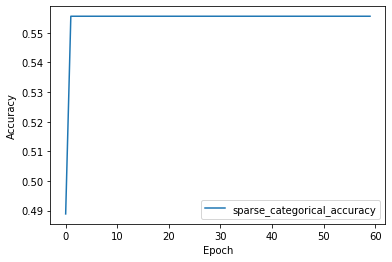

In [25]:
plt.plot(history.history['sparse_categorical_accuracy'], label = 'sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [27]:
test_loss, test_acc = model.evaluate(val_data, steps = steps_per_epoch_train, verbose=2)

3/3 - 0s - loss: 0.7593 - sparse_categorical_accuracy: 0.5000


In [28]:
test_loss, test_acc

(0.7592518130938212, 0.5)